In [55]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from scipy.sparse import csgraph
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from hodgelaplacians import HodgeLaplacians
import gudhi
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
from sklearn.manifold import MDS

Операторы Ходжа в задачах классификации

In [3]:
desktop_path = Path.home() /'OneDrive' / 'Desktop'
data_dir = desktop_path / 'cni'
data_dir_train = data_dir / '2019_CNI_TrainingRelease-master'
data_dir_test = data_dir / '2019_CNI_ValidationRelease-master'

# Load data
train_paths = sorted(list(data_dir_train.glob('Training/*/timeseries_*.csv')))
train_tss = [pd.read_csv(path) for path in train_paths]
train_phen = pd.read_csv("C:/Users/artem/OneDrive/Desktop/cni/2019_CNI_TrainingRelease-master/SupportingInfo/phenotypic_training.csv").replace(
    {"ADHD": 1, "Control": 0, "F": 0, "M": 1})

test_paths = sorted(list(data_dir_test.glob('Validation/*/timeseries_*.csv')))
test_tss = [pd.read_csv(path) for path in test_paths]
test_phen = pd.read_csv(data_dir_test / 'SupportingInfo' / 'phenotypic_validation.csv').replace(
    {"ADHD": 1, "Control": 0, "F": 0, "M": 1})

In [4]:
# calculate corr mat for train and test
train_corr_mats = [df.T.corr() for df in train_tss]
test_corr_mats = [df.T.corr() for df in test_tss]

In [5]:
# replace negative values to zero
train_corr_mats_pos = [df.clip(lower=0) for df in train_corr_mats]
test_corr_mats_pos = [df.clip(lower=0) for df in test_corr_mats]

Визуализация Rips комплекса

Rips complex is of dimension 2 - 342 simplices - 115 vertices.


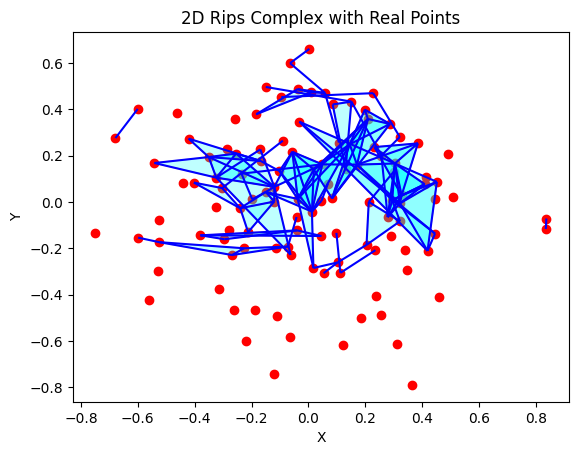

In [6]:
correlation_matrix = np.array(train_corr_mats[0], float)

# Преобразование корреляционной матрицы в матрицу расстояний
distance_matrix = 1 - correlation_matrix

# Построение Rips-комплекса
max_edge_length = 0.25  # Максимальная длина ребра для включения в комплекс
rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_edge_length)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

print(f'Rips complex is of dimension {simplex_tree.dimension()} - {simplex_tree.num_simplices()} simplices - {simplex_tree.num_vertices()} vertices.')

# Применение MDS для проецирования точек в 2D-пространство
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
points = mds.fit_transform(distance_matrix)

# Визуализация вершин и рёбер в 2D
fig, ax = plt.subplots()

ax.scatter(points[:, 0], points[:, 1], c='r', marker='o')

# Визуализация рёбер (1-мерные симплексы)
edges = []
for simplex in simplex_tree.get_skeleton(1):
    if len(simplex[0]) == 2:  # Это ребро
        i, j = simplex[0]
        if distance_matrix[i, j] <= max_edge_length:
            edges.append([points[i], points[j]])
edge_collection = LineCollection(edges, colors='b')
ax.add_collection(edge_collection)

# Визуализация треугольников (2-мерные симплексы)
triangles = []
for simplex in simplex_tree.get_skeleton(2):
    if len(simplex[0]) == 3:  # Это треугольник
        i, j, k = simplex[0]
        if distance_matrix[i, j] <= max_edge_length and distance_matrix[j, k] <= max_edge_length and distance_matrix[i, k] <= max_edge_length:
            triangles.append([points[i], points[j], points[k]])
triangle_collection = PolyCollection(triangles, facecolors='cyan', edgecolors='r', alpha=0.25)
ax.add_collection(triangle_collection)

ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Rips Complex with Real Points')
plt.show()

In [11]:
def eigen_laplas(corr_mat):
    correlation_matrix = np.array(corr_mat, float)
    distance_matrix = 1 - correlation_matrix
    rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix, max_edge_length=0.16)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
    rips_skeleton_gudhi = simplex_tree.get_skeleton(2)
    hl_1 = HodgeLaplacians(rips_skeleton_gudhi, maxdimension=2, mode='gudhi')
    evalsL, evecsL = hl_1.getHodgeSpectrum(1, 1, around_point = 0.01)
    return evecsL[0]

In [12]:
train_eigs = [eigen_laplas(corr_mat) for corr_mat in train_corr_mats_pos]

In [13]:
train_vals = np.concatenate(train_eigs,axis = 0)

In [15]:
curr_train = (train_vals.shape[0] // 200) * 200
train_vals = train_vals[:curr_train]

In [16]:
test_eigs = [eigen_laplas(corr_mat) for corr_mat in test_corr_mats_pos]

In [17]:
test_vals = np.concatenate(test_eigs,axis = 0)

In [18]:
curr_test = (test_vals.shape[0] // 40) * 40
test_vals = test_vals[:curr_test]

In [19]:
train_mats = np.vstack(np.split(train_vals, 200))
X_train = pd.concat([train_phen, pd.DataFrame(train_mats)], axis=1).drop(columns=['DX', 'Subj'])
y_train = train_phen['DX'].values

In [20]:
test_mats = np.vstack(np.split(test_vals, 40))  
X_test = pd.concat([test_phen, pd.DataFrame(test_mats)], axis=1).drop(columns=['DX', 'Subj'])
y_test = test_phen['DX'].values

In [21]:
X_train = X_train.iloc[:,:X_test.shape[1]]

In [22]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [32]:
svm_model = SVC()
param_grid = {'C': [0.01, 0.1, 1, 10, 25, 50],
              'gamma': [0.001, 0.01, 0.1, 0.5],
              'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(f'The best score: {grid.best_score_}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ................C=0.01, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ................C=0.01, gamma=0.001, k

In [36]:
svm_best = SVC(C=0.01, gamma=0.01, kernel='poly')
svm_best.fit(X_train, y_train)
X_test.columns = X_test.columns.astype(str)
y_pred = svm_best.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
accuracy_1 = accuracy_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)
roc_auc_1 = roc_auc_score(y_test, y_pred)

# Матрица ошибок для вычисления дополнительных метрик
cm_1 = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_1.ravel()

In [38]:
fdr_1 = fp / (fp + tp)  # False Discovery Rate
fnr_1 = fn / (fn + tp)  # False Negative Rate
for_1 = fn / (fn + tn)  # False Omission Rate
fpr_1 = fp / (fp + tn)  # False Positive Rate

# Вывод метрик
print(f'Accuracy: {accuracy_1}')
print(f'F1 Score: {round(f1_1,3)}')
print(f'AUC-ROC Score: {roc_auc_1}')
print(f'False Discovery Rate (FDR): {round(fdr_1,3)}')
print(f'False Negative Rate (FNR): {fnr_1}')
print(f'False Omission Rate (FOR): {round(for_1,3)}')
print(f'False Positive Rate (FPR): {fpr_1}')

Accuracy: 0.6
F1 Score: 0.619
AUC-ROC Score: 0.6
False Discovery Rate (FDR): 0.409
False Negative Rate (FNR): 0.35
False Omission Rate (FOR): 0.389
False Positive Rate (FPR): 0.45


Нормализованный лапласиан графа

In [56]:
# replace negative values to zero
train_corr_mats_pos = [df.clip(lower=0) for df in train_corr_mats]
test_corr_mats_pos = [df.clip(lower=0) for df in test_corr_mats]

In [57]:
train_laplac_mats = [csgraph.laplacian(corr_mat.values, normed=True) for corr_mat in train_corr_mats_pos]
train_eigs = np.concatenate([linalg.eigvals(corr_mat) for corr_mat in train_laplac_mats], axis=0)

In [58]:
test_laplac_mats = [csgraph.laplacian(corr_mat.values, normed=True) for corr_mat in test_corr_mats_pos]
test_eigs = np.concatenate([linalg.eigvals(corr_mat) for corr_mat in test_laplac_mats], axis=0)

In [59]:
train_eigs_by_subj = np.vstack(np.split(train_eigs, 200))  # 200 subjects in train
X_train = pd.concat([train_phen, pd.DataFrame(train_eigs_by_subj)], axis=1).drop(columns=['DX', 'Subj'])
y_train = train_phen['DX'].values

In [60]:
test_eigs_by_subj = np.vstack(np.split(test_eigs, 40))  # 40 subjects in test
X_test = pd.concat([test_phen, pd.DataFrame(test_eigs_by_subj)], axis=1).drop(columns=['DX', 'Subj'])
y_test = test_phen['DX'].values

In [61]:
X_train.columns = X_train.columns.astype(str)

In [62]:
svm_model = SVC()
param_grid = {'C': [0.01, 0.1, 1, 10, 25, 50],
              'gamma': [0.001, 0.01, 0.1, 0.5],
              'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(f'The best score: {grid.best_score_},\n'
      f'The best params: {grid.best_params_}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ................C=0.01, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ................C=0.01, gamma=0.001, k

In [70]:
svm_best = SVC(**grid.best_params_)
svm_best.fit(X_train, y_train)

SVC(C=0.01, gamma=0.01, kernel='poly')

In [71]:
X_test.columns = X_test.columns.astype(str)

In [72]:
y_pred = svm_best.predict(X_test)

In [73]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Матрица ошибок для вычисления дополнительных метрик
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

In [74]:
fdr = fp / (fp + tp)  # False Discovery Rate
fnr = fn / (fn + tp)  # False Negative Rate
for_ = fn / (fn + tn)  # False Omission Rate
fpr = fp / (fp + tn)  # False Positive Rate

# Вывод метрик
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'AUC-ROC Score: {roc_auc}')
print(f'False Discovery Rate (FDR): {fdr}')
print(f'False Negative Rate (FNR): {fnr}')
print(f'False Omission Rate (FOR): {for_}')
print(f'False Positive Rate (FPR): {fpr}')

Accuracy: 0.525
F1 Score: 0.5365853658536586
AUC-ROC Score: 0.525
False Discovery Rate (FDR): 0.47619047619047616
False Negative Rate (FNR): 0.45
False Omission Rate (FOR): 0.47368421052631576
False Positive Rate (FPR): 0.5


In [75]:
metrics_1 = {
    'Method': 'Hodge laplacian',
    'Accuracy': accuracy_1,
    'F1 Score': round(f1_1, 3),
    'AUC-ROC': roc_auc_1,
    'FDR': round(fdr_1, 3),
    'FNR': fnr_1,
    'FOR': round(for_1, 3),
    'FPR': fpr_1
}

metrics_2 = {
    'Method': 'Csgraph Laplacian',
    'Accuracy': round(accuracy, 3),
    'F1 Score': round(f1, 3),
    'AUC-ROC': round(roc_auc, 3),
    'FDR': round(fdr, 3),
    'FNR': round(fnr, 3),
    'FOR': round(for_, 3),
    'FPR': round(fpr, 3)
}
metrics_df = pd.DataFrame([metrics_1, metrics_2])

# Транспонирование DataFrame для удобного отображения
metrics_df = metrics_df.set_index('Method')

In [76]:
metrics_df.T

Method,Hodge laplacian,Csgraph Laplacian
Accuracy,0.600,0.525
F1 Score,0.619,0.537
AUC-ROC,0.600,0.525
FDR,0.409,0.476
FNR,0.350,0.450
FOR,0.389,0.474
FPR,0.450,0.500
